Define values for Data Points

In [761]:
!pip install numpy
!pip install pandas 
!pip install matplotlib

In [762]:
import numpy as np
import pandas as pd
import random

In [763]:
#Here i=0,1,2...20, returns float
def value_func(i):
    return round(-2+0.2*i,2)

# Returns list of values that x1,x2 can take
def value_gen(max_val):
    i_list = np.linspace(0, 20, num = 21,dtype=int)
    print("Range of i and j is : ",i_list) # Gives the range of i,j
    values_list=list(map(value_func,i_list))
    print("List of values",values_list)
    return values_list



In [764]:
values_list=value_gen(20)

Range of i and j is :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
List of values [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [765]:
#Returns a 441x2 np_array which is the training data. 441 samples with 2 input features each

def random_train_samples(value_list):
    train_data = []
    for num_samples in range(441):
        row = []  
        for num_features in range(2):
            row.append(random.choice(value_list))
        train_data.append(row) 
    train_data=np.array(train_data)
    return train_data


# # Checking for sequential data
# import itertools
# def sequential_train_samples(value_list):
#     permutations = list(itertools.product(value_list, repeat=2))
#     train_data = np.array(permutations)
#     return train_data



In [766]:
#Save train_data
train_data=random_train_samples(values_list)
# train_data=sequential_train_samples(values_list)

In [767]:
print("Shape of Train data is :",train_data.shape)


Shape of Train data is : (441, 2)


In [768]:
# Visualise Train Data
TrainData_df=pd.DataFrame(train_data,columns=['x1','x2'])
TrainData_df

,x1,x2
0,-2.0,0.8
1,0.0,1.6
2,0.4,0.2
3,-1.0,0.4
4,-1.8,1.8
...,...,...
436,-0.4,-1.6
437,-0.4,1.4
438,0.4,0.8
439,0.8,1.0


In [769]:
# train_pt is a 1x2 np array, returns int
def squared_sum(train_pt):
    return (train_pt[0]**2)+(train_pt[1]**2)
            
        


In [770]:
# Returns a 441x1 np array containing the output labels as per f(x1,x2)

def train_labels(train_data):
    labels=[]       #Output Labels
    square_sum=[]   # To evaluate (x1^2 + x2^2) , returns (441,1)
    for i in range(train_data.shape[0]):
        square_sum.append(squared_sum(train_data[i]))
        if squared_sum(train_data[i])<=1:
            labels.append(1)
        else:
            labels.append(-1)
    labels=np.array(labels)
    labels=np.reshape(labels,(441,1))
    square_sum=np.array(square_sum)
    square_sum=np.reshape(square_sum,(441,1))
    return labels,square_sum

op_labels,squared_op=train_labels(train_data)
        

In [771]:
op_labels

array([[-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],

In [772]:
# Function to create a dataframe to crosscheck function outputs

def create_df(np_array,op_labels,squared_op):
    columns=['x1','x2']
    df=pd.DataFrame(np_array,columns=columns)
    df['Squares']=squared_op
    df['Output']=op_labels
    return df
    
df=create_df(train_data,op_labels,squared_op)

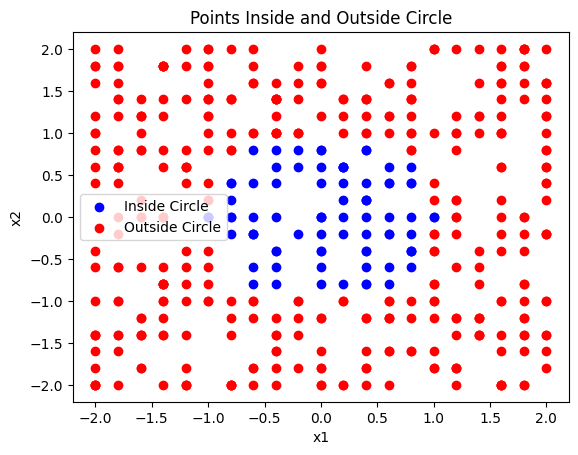

In [773]:
import matplotlib.pyplot as plt

# # Example data
# data = np.random.randn(441, 2)  # Replace with your actual data
# labels = np.random.randint(0, 2, size=(441, 1))  # Replace with your actual labels

# Separate the points based on labels
inside_circle = train_data[op_labels.flatten() == 1]
outside_circle = train_data[op_labels.flatten() == -1]

# Plotting
plt.scatter(inside_circle[:, 0], inside_circle[:, 1], color='blue', label='Inside Circle')
plt.scatter(outside_circle[:, 0], outside_circle[:, 1], color='red', label='Outside Circle')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Points Inside and Outside Circle')
plt.legend()
plt.show()


In [774]:
Y


array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
      

In [775]:
#returns rbf centres-441x2 matrix

def centres(train_data):
    return train_data


rbf_centres=centres(train_data)
print(rbf_centres)
    

[[-2.   0.8]
 [ 0.   1.6]
 [ 0.4  0.2]
 [-1.   0.4]
 [-1.8  1.8]
 [-1.2 -2. ]
 [-1.8  1.4]
 [-1.8  0.6]
 [-0.6  2. ]
 [ 0.8 -1.2]
 [-1.6  1.2]
 [ 1.  -1. ]
 [-0.8 -1. ]
 [ 1.8  2. ]
 [-1.4  1.8]
 [-1.4  1.8]
 [-1.4 -0.8]
 [-1.6  1.2]
 [ 0.4  1. ]
 [-1.8  0.6]
 [ 1.4 -0.4]
 [ 0.   0.6]
 [-1.4 -1.4]
 [ 0.6 -0.2]
 [-1.4 -0.8]
 [ 1.2  2. ]
 [ 1.6  1. ]
 [ 0.8  1.6]
 [-1.8  1.8]
 [-0.6 -0.6]
 [-0.4  1. ]
 [ 0.4  0.8]
 [-0.4 -2. ]
 [ 2.  -1.4]
 [-0.4 -0.6]
 [-0.6 -2. ]
 [ 2.   0.4]
 [ 1.  -1.6]
 [-1.8  1.6]
 [-1.4 -1.2]
 [-1.6  0. ]
 [ 0.4 -0.8]
 [ 1.6  1.8]
 [-0.6 -0.2]
 [-0.6  0.4]
 [ 1.6  1. ]
 [-1.4  1.8]
 [ 0.6  0. ]
 [ 1.2  0.8]
 [ 0.   1.2]
 [-1.8  0. ]
 [-0.4 -0.4]
 [ 1.4  2. ]
 [-2.   1.6]
 [-1.8  1.2]
 [ 1.4  1.2]
 [ 2.   1.2]
 [-0.8  0. ]
 [-1.8  0.8]
 [-1.2 -0.6]
 [-1.   0.2]
 [-1.  -0.6]
 [ 1.6 -2. ]
 [ 0.2 -2. ]
 [-1.6 -1.4]
 [-1.6 -1.8]
 [-0.6 -1.8]
 [ 1.  -0.8]
 [ 0.4  1.2]
 [ 0.2 -0.2]
 [ 0.   0. ]
 [ 2.  -1. ]
 [ 1.   2. ]
 [ 0.   0. ]
 [ 0.8 -0.4]
 [-0.8  1. ]
 [ 1.2  1. ]

In [776]:
# def gaussian_rbf(ip_vector,centre_vector,sig):
#     expp=1/(2*(sig**2))*(np.exp(-(np.square(r_arr))))
#     return expp

#ip_array- 441x2, center_vector-1x2 ,sigma-scalar
def gaussian_kernel(ip_array, center_vector, sigma):
#     print(ip_array - center_vector)
    x=np.exp(-np.linalg.norm(ip_array - center_vector)**2 / (2 * sigma**2))
#     print(np.array(x).shape)
    return x

def rbf(train_data,centres,sigma):
    phi = np.zeros((train_data.shape[0], centres.shape[0]))
    
    for i in range(train_data.shape[0]):
        for j in range(centres.shape[0]):
            phi[i, j] = gaussian_kernel(train_data[i], centres[j], sigma)
#             print(phi[i, j])
    return phi

# arr=gaussian_kernel(train_data,rbf_centres[0],0.1)
rbf_output=rbf(train_data,rbf_centres,10000)


In [777]:
def weights(rbf_output,op_labels):
#     G_pinv_1=np.dot(np.linalg.inv(np.dot(rbf_output.T,rbf_output)),rbf_output.T)
    G_pinv=np.linalg.pinv(rbf_output)
    D=op_labels
#     W_1=np.dot(G_pinv_1,D)
    W=np.dot(G_pinv,D)
#     print(W_1)
    print(W)
    return W

W=weights(rbf_output,op_labels)

[[-4.16513021e+03]
 [-3.73872554e+02]
 [ 7.46221032e+02]
 [-2.08394143e+03]
 [-3.99939828e+03]
 [-1.92494344e+03]
 [-3.90661835e+03]
 [-3.72105849e+03]
 [-1.65969764e+03]
 [ 1.86631441e+03]
 [-3.46254662e+03]
 [ 2.21760620e+03]
 [-1.36152979e+03]
 [ 3.11248362e+03]
 [-3.20403476e+03]
 [-3.20403476e+03]
 [-2.60096512e+03]
 [-3.46254662e+03]
 [ 5.60661143e+02]
 [-3.72105849e+03]
 [ 2.87379986e+03]
 [-1.41922498e+02]
 [-2.46179517e+03]
 [ 1.23668277e+03]
 [-2.60096512e+03]
 [ 1.91943832e+03]
 [ 2.94675178e+03]
 [ 1.21685475e+03]
 [-3.99939828e+03]
 [-1.05662799e+03]
 [-1.03006600e+03]
 [ 6.07051096e+02]
 [-3.34216370e+02]
 [ 4.29879498e+03]
 [-6.58946198e+02]
 [-7.31898138e+02]
 [ 3.88128525e+03]
 [ 2.35677613e+03]
 [-3.95300832e+03]
 [-2.50818515e+03]
 [-3.18420679e+03]
 [ 9.78170901e+02]
 [ 2.76119183e+03]
 [-1.14940794e+03]
 [-1.28857785e+03]
 [ 2.94675178e+03]
 [-3.20403476e+03]
 [ 1.19029278e+03]
 [ 2.19777821e+03]
 [-2.81092406e+02]
 [-3.58188856e+03]
 [-7.05336189e+02]
 [ 2.3171200

In [778]:
def predict(W,G):
    Y=np.dot(W.T,G)
    Y=np.array(Y)
    Y=np.sign(Y)
    return Y.T

Y=predict(W,rbf_output)
Y.shape

    
    

(441, 1)

In [779]:
# Calculate accuracy
accuracy = np.mean(Y == op_labels) * 100
print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 81.63%


In [780]:
def calculate_mse(predictions, actual_labels):
    return np.mean((predictions - actual_labels) ** 2)*100
calculate_mse(Y,op_labels)

73.46938775510205

In [781]:
# df_2=pd.DataFrame(train_data-rbf_centres[0],columns=['xi1-ti1','xi2-ti2'])
arr=gaussian_kernel(train_data,rbf_centres[0],0.1)
# print(arr)
# df_2=pd.DataFrame(arr,columns=['xi1-ti1','xi2-ti2'])
print(rbf_centres[0])
# # print(df)
# print(df_2)


[-2.   0.8]


In [782]:
a1=np.array([[1,2],[2,3],[4,5]])
a2=np.array([[2,3]])
print(a1-a2)

[[-1 -1]
 [ 0  0]
 [ 2  2]]


In [783]:
print(rbf_output.shape)

(441, 441)


In [784]:
for index, element in np.ndenumerate(rbf_output):
    print("Index:", index, "Element:", element)

Index: (0, 0) Element: 1.0
Index: (0, 1) Element: 0.9999999768000003
Index: (0, 2) Element: 0.9999999694000005
Index: (0, 3) Element: 0.9999999942
Index: (0, 4) Element: 0.9999999948
Index: (0, 5) Element: 0.9999999576000009
Index: (0, 6) Element: 0.9999999980000001
Index: (0, 7) Element: 0.9999999996
Index: (0, 8) Element: 0.9999999830000001
Index: (0, 9) Element: 0.9999999408000018
Index: (0, 10) Element: 0.9999999984
Index: (0, 11) Element: 0.9999999388000018
Index: (0, 12) Element: 0.9999999766000003
Index: (0, 13) Element: 0.9999999206000032
Index: (0, 14) Element: 0.9999999932
Index: (0, 15) Element: 0.9999999932
Index: (0, 16) Element: 0.9999999854000001
Index: (0, 17) Element: 0.9999999984
Index: (0, 18) Element: 0.9999999710000004
Index: (0, 19) Element: 0.9999999996
Index: (0, 20) Element: 0.9999999350000021
Index: (0, 21) Element: 0.9999999798000002
Index: (0, 22) Element: 0.9999999740000003
Index: (0, 23) Element: 0.9999999612000008
Index: (0, 24) Element: 0.999999985400000

Index: (44, 308) Element: 0.9999999596000008
Index: (44, 309) Element: 0.9999999676000005
Index: (44, 310) Element: 0.9999999830000001
Index: (44, 311) Element: 0.9999999932
Index: (44, 312) Element: 0.9999999852000001
Index: (44, 313) Element: 0.9999999704000004
Index: (44, 314) Element: 0.9999999896
Index: (44, 315) Element: 0.9999999928000001
Index: (44, 316) Element: 0.999999987
Index: (44, 317) Element: 0.9999999998
Index: (44, 318) Element: 0.9999999984
Index: (44, 319) Element: 0.9999999740000003
Index: (44, 320) Element: 0.9999999894
Index: (44, 321) Element: 0.9999999974
Index: (44, 322) Element: 0.9999999756000003
Index: (44, 323) Element: 0.9999999672000005
Index: (44, 324) Element: 0.9999999702000004
Index: (44, 325) Element: 0.999999987
Index: (44, 326) Element: 0.9999999996
Index: (44, 327) Element: 0.9999999710000004
Index: (44, 328) Element: 0.999999955000001
Index: (44, 329) Element: 0.9999999942
Index: (44, 330) Element: 0.9999999894
Index: (44, 331) Element: 0.999999

Index: (61, 369) Element: 0.9999999510000012
Index: (61, 370) Element: 0.9999999644000006
Index: (61, 371) Element: 0.9999999900000001
Index: (61, 372) Element: 0.9999999710000004
Index: (61, 373) Element: 0.999999995
Index: (61, 374) Element: 0.9999999686000005
Index: (61, 375) Element: 0.9999999750000003
Index: (61, 376) Element: 0.9999999902000001
Index: (61, 377) Element: 0.9999999896
Index: (61, 378) Element: 0.9999999926
Index: (61, 379) Element: 0.9999999982
Index: (61, 380) Element: 0.9999999768000003
Index: (61, 381) Element: 0.9999999864000001
Index: (61, 382) Element: 0.9999999308000024
Index: (61, 383) Element: 0.999999992
Index: (61, 384) Element: 0.999999995
Index: (61, 385) Element: 0.9999999542000011
Index: (61, 386) Element: 0.999999995
Index: (61, 387) Element: 0.9999999840000001
Index: (61, 388) Element: 0.999999987
Index: (61, 389) Element: 0.9999999966
Index: (61, 390) Element: 0.999999987
Index: (61, 391) Element: 0.999999955000001
Index: (61, 392) Element: 0.9999

Index: (65, 182) Element: 0.9999999404000017
Index: (65, 183) Element: 0.9999999180000033
Index: (65, 184) Element: 0.9999999894
Index: (65, 185) Element: 0.999999995
Index: (65, 186) Element: 0.9999999902000001
Index: (65, 187) Element: 0.9999999750000003
Index: (65, 188) Element: 0.9999999584000009
Index: (65, 189) Element: 0.9999999728000004
Index: (65, 190) Element: 0.9999999486000013
Index: (65, 191) Element: 0.9999998774000075
Index: (65, 192) Element: 0.9999999702000004
Index: (65, 193) Element: 0.999999955800001
Index: (65, 194) Element: 0.9999999662000005
Index: (65, 195) Element: 0.9999999702000004
Index: (65, 196) Element: 0.9999999470000014
Index: (65, 197) Element: 0.9999999014000048
Index: (65, 198) Element: 0.9999999478000013
Index: (65, 199) Element: 0.9999999334000023
Index: (65, 200) Element: 0.9999999532000011
Index: (65, 201) Element: 0.9999999878000001
Index: (65, 202) Element: 1.0
Index: (65, 203) Element: 0.9999999806000002
Index: (65, 204) Element: 0.99999995360

Index: (68, 346) Element: 0.9999999854000001
Index: (68, 347) Element: 0.9999999854000001
Index: (68, 348) Element: 0.9999999896
Index: (68, 349) Element: 0.999999996
Index: (68, 350) Element: 0.9999999644000006
Index: (68, 351) Element: 0.9999999606000007
Index: (68, 352) Element: 0.9999999984
Index: (68, 353) Element: 0.9999999830000001
Index: (68, 354) Element: 0.9999999416000017
Index: (68, 355) Element: 0.9999999662000005
Index: (68, 356) Element: 0.9999999712000004
Index: (68, 357) Element: 0.9999999416000017
Index: (68, 358) Element: 0.9999999542000011
Index: (68, 359) Element: 0.9999999980000001
Index: (68, 360) Element: 0.9999999456000015
Index: (68, 361) Element: 0.9999999966
Index: (68, 362) Element: 0.9999999374000019
Index: (68, 363) Element: 0.999999953600001
Index: (68, 364) Element: 0.9999999704000004
Index: (68, 365) Element: 0.9999999800000002
Index: (68, 366) Element: 0.9999999928000001
Index: (68, 367) Element: 0.999999955000001
Index: (68, 368) Element: 0.999999986

Index: (72, 24) Element: 0.9999999320000024
Index: (72, 25) Element: 0.9999999998
Index: (72, 26) Element: 0.9999999932
Index: (72, 27) Element: 0.999999999
Index: (72, 28) Element: 0.9999999606000007
Index: (72, 29) Element: 0.9999999534000011
Index: (72, 30) Element: 0.9999999852000001
Index: (72, 31) Element: 0.999999991
Index: (72, 32) Element: 0.999999910200004
Index: (72, 33) Element: 0.999999937200002
Index: (72, 34) Element: 0.9999999564000009
Index: (72, 35) Element: 0.9999999072000043
Index: (72, 36) Element: 0.9999999822000002
Index: (72, 37) Element: 0.9999999352000021
Index: (72, 38) Element: 0.9999999600000008
Index: (72, 39) Element: 0.9999999200000032
Index: (72, 40) Element: 0.9999999462000014
Index: (72, 41) Element: 0.9999999590000008
Index: (72, 42) Element: 0.9999999980000001
Index: (72, 43) Element: 0.9999999630000007
Index: (72, 44) Element: 0.9999999744000003
Index: (72, 45) Element: 0.9999999932
Index: (72, 46) Element: 0.9999999710000004
Index: (72, 47) Elemen

Index: (125, 394) Element: 0.9999999456000015
Index: (125, 395) Element: 0.9999999534000011
Index: (125, 396) Element: 0.9999999686000005
Index: (125, 397) Element: 0.9999999728000004
Index: (125, 398) Element: 0.999999937200002
Index: (125, 399) Element: 0.9999999158000036
Index: (125, 400) Element: 0.999999996
Index: (125, 401) Element: 0.9999999992
Index: (125, 402) Element: 0.999999936000002
Index: (125, 403) Element: 0.9999999830000001
Index: (125, 404) Element: 0.999999953600001
Index: (125, 405) Element: 0.999999953600001
Index: (125, 406) Element: 0.9999999414000017
Index: (125, 407) Element: 0.9999999308000024
Index: (125, 408) Element: 0.9999999932
Index: (125, 409) Element: 0.9999999152000036
Index: (125, 410) Element: 0.9999999996
Index: (125, 411) Element: 0.9999999374000019
Index: (125, 412) Element: 0.9999999254000028
Index: (125, 413) Element: 0.9999999320000024
Index: (125, 414) Element: 0.9999999064000044
Index: (125, 415) Element: 0.9999999422000017
Index: (125, 416)

Index: (144, 155) Element: 0.9999999856000001
Index: (144, 156) Element: 0.9999999822000002
Index: (144, 157) Element: 0.9999999980000001
Index: (144, 158) Element: 0.9999999576000009
Index: (144, 159) Element: 0.9999999928000001
Index: (144, 160) Element: 0.9999999750000003
Index: (144, 161) Element: 0.9999999702000004
Index: (144, 162) Element: 0.9999999854000001
Index: (144, 163) Element: 0.9999999704000004
Index: (144, 164) Element: 0.9999999864000001
Index: (144, 165) Element: 0.9999999894
Index: (144, 166) Element: 0.9999999518000011
Index: (144, 167) Element: 0.9999999704000004
Index: (144, 168) Element: 0.9999999134000037
Index: (144, 169) Element: 0.9999999576000009
Index: (144, 170) Element: 0.9999999830000001
Index: (144, 171) Element: 0.9999999708000005
Index: (144, 172) Element: 1.0
Index: (144, 173) Element: 0.9999999456000015
Index: (144, 174) Element: 0.9999999350000021
Index: (144, 175) Element: 0.9999999822000002
Index: (144, 176) Element: 0.999999987
Index: (144, 177

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [785]:
op_df=pd.DataFrame(op_labels,columns=['Actual'])
op_df['Predicted']=Y
op_df
op_df.to_csv('outputs.csv', index=True)

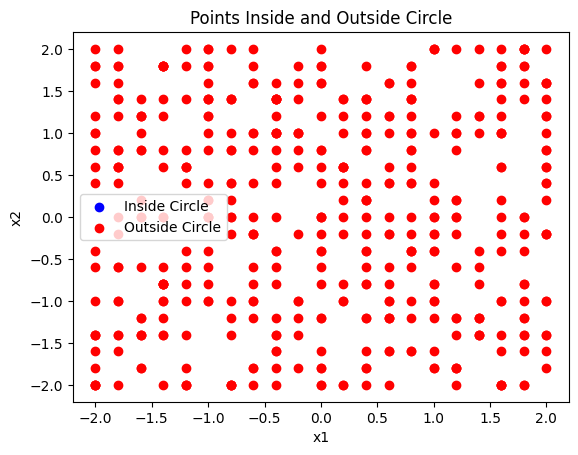

In [786]:
inside_circle = train_data[Y.flatten() == 1.0]
outside_circle = train_data[Y.flatten() == -1.0]

# Plotting
plt.scatter(inside_circle[:, 0], inside_circle[:, 1], color='blue', label='Inside Circle')
plt.scatter(outside_circle[:, 0], outside_circle[:, 1], color='red', label='Outside Circle')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Points Inside and Outside Circle')
plt.legend()
plt.show()


In [787]:
(pd.DataFrame(rbf_output)).to_csv('rbf.csv',index=True)